In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [275]:
class c_method:
    """This class will containt the information of a single method.
    The method is defined as a combination of a program with a particular set of keywords.
    So two different newtonX simulations with different timesteps are two different methods.
    The parameters of the simulation are variables of the class, the time dependent properties
    are in the self.data dataframe
    """

    def __init__(self, program: str = None) -> None:
        self.time_fs2au = 41.34137221718
        if program:
            self.add_program(program)


    def add_program(self, program: str) -> None:
        prog = program.split(sep='_')

        if (prog[0].lower() == 'newtonx' 
         or prog[0].lower() == 'nx'):
            self.prog_name = 'NewtonX'
            self.set_nx_defaults()

        elif (prog[0].lower() == 'qdct'):
            self.prog_name = 'qdct'
            self.set_qdct_defaults()

        else:
            self.prog_name = prog[0]

        if len(prog) == 2:
            self.prog_version = prog[1]
        else:
            self.prog_version = 'not specified'


    def print_program(self):
        print(f'Program used: {self.prog_name} Version {self.prog_version}')

    def get_program(self) -> (str, str):
        return self.prog_name, self.prog_version

    def add_description(self, description: str):
        self.description = description

    def add_path(self, path: str):
        self.path = path

    def get_path(self) -> str:
        return self.path

    def print_path(self):
        print(self.path)


    # dynamics parameter
    def set_timestep(self, ts: float) -> None:
        self.time_step = ts

    def get_timestep(self) -> None:
        return self.time_step

    def set_substeps(self, sub: int) -> None:
        self.substeps = sub

    def get_substeps(self) -> None:
        return self.substeps

    def print_prog_params(self) -> None:
        if self.prog_name == 'NewtonX':
            self.print_nx_params()
        elif self.prog_name == 'qdct':
            self.print_qdct_params()

    def get_prog_params(self) -> dict:
        params = dict()
        params['data'] = list(self.df.columns)
        if self.prog_version == 'not specified':
            params['program'] = f'{self.prog_name}'
        else:
            params['program'] = f'{self.prog_name}_{self.prog_version}'
        params['timestep'] = self.time_step

        if self.prog_name == 'NewtonX':
            params['decoherence'] = self.decoherence
            params['substeps'] = self.substeps

        if self.prog_name == 'qdct':
            params['classical'] = self.classical_calc
            params['substeps'] = self.substeps

        return params

    # newtonx parameters
    def set_nx_defaults(self) -> None:
        self.set_timestep(0.5)
        self.set_decoherence('off')
        self.set_substeps(20)

    def set_decoherence(self, deco: str) -> None:
        self.decoherence = deco

    def get_decoherence(self) -> None:
        return self.decoherence

    def print_nx_params(self) -> None:
        print(f'Time step: {self.time_step} fs')
        print(f'Decoherence: {self.decoherence}')
        print(f'Substeps: {self.substeps}')


    # qdct parameters
    def set_classical_calculation(self, classical: str) -> None:
        self.classical_calc = classical

    def set_qdct_defaults(self) -> None:
        self.set_timestep(0.5)
        self.set_substeps(0)

    def print_qdct_params(self) -> None:
        print(f'Time step: {self.time_step} fs')
        print(f'Substeps: {self.substeps}')
        print(f'Classical calculation: {self.classical_calc}')


    # extrat data
    def parse_average_pop(self) -> None:
        if self.prog_name == 'NewtonX':
            self.parse_nx_average_pop()
        elif self.prog_name == 'qdct':
            self.parse_qdct_average_pop()
       
        self.set_timestep(self.df['time'][1] - self.df['time'][0])
    

    def parse_nx_average_pop(self) -> None:
        try:
            self.df = pd.read_csv(f'{self.path}/populations.csv',
                                  names=['time', 'S0 pop', 'S1 pop'],
                                  skiprows=1)

            self.df['norm'] = self.df['S0 pop'] + self.df['S1 pop']
        except:
            print(f'no {self.path}/populations.csv')

    def parse_qdct_average_pop(self) -> None:
        try:
            self.df = pd.read_csv(f'{self.path}/elec_pop.dat',
                                  names=['time', 'norm', 'S0 pop', 'S1 pop'],
                                  sep='\s+',
                                  skiprows=1)
            self.df = self.df[['time', 'S0 pop', 'S1 pop', 'norm']]
            
            self.df['time'] = self.df['time']/self.time_fs2au
        except:
            print(f'no file {self.path}/elec_pop.dat')


    def get_data(self):
        try:
            return self.df
        except:
            print(f'no data for this method')

In [310]:
class c_init_cond:
    """class to collet the different methods used of an individual initial condition
    the method class is indicated by a dictionary
    """
    def __init__(self, condition: str) -> None:
        self.initial_cond = condition
        self.methods = dict()


    def add_method(self, method_name: str, method_class: c_method = None) -> None:
        if method_class:
            self.methods[method_name] = method_class
        else:
            self.methods[method_name] = c_method()


    def get_method(self, method_name: str) -> c_method:
        try:
            return self.methods[method_name]
        except:
            print(f'No method {method_name}')

    def get_method_names(self) -> list:
        return list(self.methods.keys())

    def summarize_methods(self, cond_name) -> list:
        summary = []
        for method_name, meth in self.methods.items():
            summary.append(meth.get_prog_params())
            summary[-1]['init_cond'] = self.initial_cond
            summary[-1]['method_name'] = method_name
            summary[-1]['cond_name'] = cond_name

        return summary


In [319]:
class c_model:
    """Class to collet the different innitial conditions for an individual analytical model
    the initial conditions are pointed by a dictionary
    """

    def __init__(self, model: str) -> None:
        self.model = model
        self.conditions = dict()


    def add_init_cond(self, cond_name: str, cond_class: c_init_cond = None) -> None:
        if cond_name in self.conditions:
            if cond_class:
                for meth in cond_class.get_method_names():
                    self.conditions[cond_name].add_method(meth, cond_class.get_method(meth))
        else:
            if cond_class:
                self.conditions[cond_name] = cond_class
            else:
                self.conditions[cond_name] = c_init_cond()


    def get_init_cond(self, cond_name: str) -> c_init_cond:
        try:
            return self.conditions[cond_name]
        except:
            print(f'No initial condition {cond_name}')

    def summarize(self) -> None:
        self.summary = []

        for name, cond in self.conditions.items():
            self.summary= self.summary + cond.summarize_methods(name)

        self.summary = pd.DataFrame(self.summary).fillna('')

    def get_summary(self) -> pd.DataFrame:
        try:
            return self.summary
        except:
            self.summarize()
            return self.summary

    def filter_data(self, filter_values: dict) -> pd.DataFrame:
        query = ''

        for key, val in filter_values.items():
            query += f" and {key} == {val}"

        query = query[5:]
        
        return pd.DataFrame(self.get_summary().query(query))

    def plot(self, filter_values: dict, properties: list) -> None:
        data = self.filter_data(filter_values)

        for meth, cond in zip(data.method_name, data.cond_name):
            tmp_data = self.conditions[cond].get_method(meth).get_data()

            for p in properties:
                if p in tmp_data:
                    # print(tmp_data[p])
                    plt.plot(tmp_data['time'], tmp_data[p], label=f'{p}_{cond}_{meth}')

        plt.legend()
        plt.xlabel('time (fs)')
        plt.show()
        # plt.savefig('figure.png')

In [320]:
def populate_tully_2() -> c_model:
    r_path = '/data/Rafael/Projects/08-QDCT/data/02-tully_2'

    t2 = c_model('tully 2')
    dict_init_cond = {'mom5' : '02-mom_5',
                      'mom8' : '03-mom_8',
                      'mom10': '04-mom_10',
                      'mom16': '05-mom_16',
                      'mom20': '06-mom_20',
                      'mom30': '07-mom_30'}
    
    print(f'Starting to read newtonX trajectories')
    for key, val in dict_init_cond.items():
        print(f'Reading initial condition: {key}')

        tmp_meth = c_method('nx_cs')
        tmp_meth.add_path(f'{r_path}/{val}/01-NX_NS/01-ts0.1fs/01-decon_mson')
        tmp_meth.parse_average_pop()
        # tmp_meth.set_timestep(0.1)

        init_cond = c_init_cond(key)
        init_cond.add_method('nx', tmp_meth)

        t2.add_init_cond(key, init_cond)

    print('')
    print(f'Starting to read qdct trajectories')
    for key, val in dict_init_cond.items():
        print(f'Reading initial condition: {key}')

        tmp_meth = c_method('qdct')
        tmp_meth.add_path(f'{r_path}/{val}/05-qdct_nx')
        tmp_meth.parse_average_pop()
        tmp_meth.set_substeps(10)
        tmp_meth.set_classical_calculation('nx')

        init_cond = c_init_cond(key)
        init_cond.add_method('qdct', tmp_meth)

        t2.add_init_cond(key, init_cond)

    return t2

In [321]:
def save_model(model: c_model, f_name: str) -> None:
    with open(f'{f_name}.pikle', 'wb') as data_file:
        pickle.dump(model, data_file)

def read_model(f_name: str) -> c_model:
    with open(f'{f_name}.pikle', 'rb') as data_file:
        return pickle.load(data_file)

In [322]:
def filter_data(filter_values: dict, full_data: pd.DataFrame) -> pd.DataFrame:
    query = ''

    for key, val in filter_values.items():
        query += f" and {key} == {val}"

    query = query[5:]
    
    return pd.DataFrame(full_data.query(query))

In [323]:
t2 = populate_tully_2()

Starting to read newtonX trajectories
Reading initial condition: mom5
Reading initial condition: mom8
Reading initial condition: mom10
Reading initial condition: mom16
Reading initial condition: mom20
Reading initial condition: mom30

Starting to read qdct trajectories
Reading initial condition: mom5
Reading initial condition: mom8
Reading initial condition: mom10
Reading initial condition: mom16
Reading initial condition: mom20
Reading initial condition: mom30


In [324]:
t2.get_summary()

,data,program,timestep,decoherence,substeps,init_cond,method_name,cond_name,classical
0,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.10,off,20,mom5,nx,mom5,
1,"[time, S0 pop, S1 pop, norm]",qdct,0.02,,10,mom5,qdct,mom5,nx
2,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.10,off,20,mom8,nx,mom8,
3,"[time, S0 pop, S1 pop, norm]",qdct,0.02,,10,mom8,qdct,mom8,nx
4,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.10,off,20,mom10,nx,mom10,
5,"[time, S0 pop, S1 pop, norm]",qdct,0.02,,10,mom10,qdct,mom10,nx
6,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.10,off,20,mom16,nx,mom16,
7,"[time, S0 pop, S1 pop, norm]",qdct,0.02,,10,mom16,qdct,mom16,nx
8,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.10,off,20,mom20,nx,mom20,
9,"[time, S0 pop, S1 pop, norm]",qdct,0.02,,10,mom20,qdct,mom20,nx


In [325]:
get_vals = {'decoherence': "'off'",
            'init_cond': "'mom16'"}

t2.filter_data(get_vals)

,data,program,timestep,decoherence,substeps,init_cond,method_name,cond_name,classical
6,"[time, S0 pop, S1 pop, norm]",NewtonX_cs,0.1,off,20,mom16,nx,mom16,


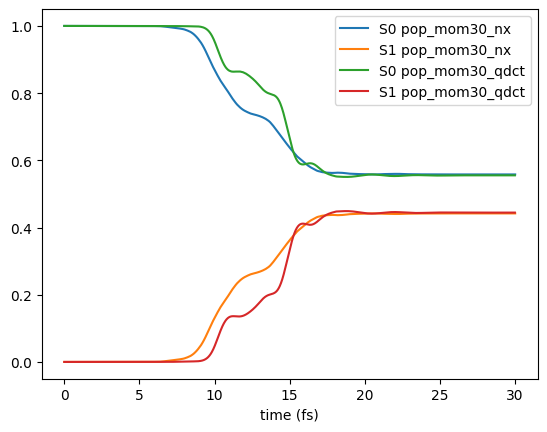

In [330]:
get_vals = {'init_cond': "'mom30'"}
data = ['S0 pop', 'S1 pop']

t2.plot(get_vals, data)